In [39]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [15]:
train_dir = 'data/train'
filepaths = []
labels = []

folds = os.listdir(train_dir)
for fold in folds:
    foldpath = os.path.join(train_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [16]:
train_dir

'data/train'

In [17]:
train_df

,filepaths,labels
0,data/train\angry\Training_10118481.jpg,angry
1,data/train\angry\Training_10120469.jpg,angry
2,data/train\angry\Training_10131352.jpg,angry
3,data/train\angry\Training_10161559.jpg,angry
4,data/train\angry\Training_1021836.jpg,angry
...,...,...
28704,data/train\surprise\Training_99916297.jpg,surprise
28705,data/train\surprise\Training_99924420.jpg,surprise
28706,data/train\surprise\Training_99937001.jpg,surprise
28707,data/train\surprise\Training_99951755.jpg,surprise


In [18]:
test_dir = 'data/test'
filepaths = []
labels = []

folds = os.listdir(test_dir)
for fold in folds:
    foldpath = os.path.join(test_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

In [19]:
test_df

,filepaths,labels
0,data/test\angry\PrivateTest_10131363.jpg,angry
1,data/test\angry\PrivateTest_10304478.jpg,angry
2,data/test\angry\PrivateTest_1054527.jpg,angry
3,data/test\angry\PrivateTest_10590091.jpg,angry
4,data/test\angry\PrivateTest_1109992.jpg,angry
...,...,...
7173,data/test\surprise\PublicTest_98089595.jpg,surprise
7174,data/test\surprise\PublicTest_98567249.jpg,surprise
7175,data/test\surprise\PublicTest_98972870.jpg,surprise
7176,data/test\surprise\PublicTest_99242645.jpg,surprise


In [20]:
train_df, valid_df = train_test_split(train_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [21]:
train_df

,filepaths,labels
22354,data/train\sad\Training_4071905.jpg,sad
4238,data/train\disgust\Training_62572176.jpg,disgust
2279,data/train\angry\Training_61879181.jpg,angry
15882,data/train\neutral\Training_12609029.jpg,neutral
4504,data/train\fear\Training_11790079.jpg,fear
...,...,...
28636,data/train\surprise\Training_98197769.jpg,surprise
17730,data/train\neutral\Training_45711010.jpg,neutral
28030,data/train\surprise\Training_79781970.jpg,surprise
15725,data/train\happy\Training_99764347.jpg,happy


In [22]:
# crobed image size
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

In [25]:
tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)
train_generator = tr_gen.flow_from_dataframe(
        train_df,
        x_col= 'filepaths',
        y_col= 'labels',
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = tr_gen.flow_from_dataframe(
        valid_df,
        x_col= 'filepaths',
        y_col= 'labels',
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')


Found 17225 validated image filenames belonging to 7 classes.
Found 11484 validated image filenames belonging to 7 classes.


In [26]:
# Create the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

In [27]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [28]:
num_train = 28709
num_val = 7178
batch_size = 64
num_epoch = 50

In [29]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0001, decay=1e-6),metrics=['accuracy'])
model_info = model.fit(
    train_generator,
    steps_per_epoch=num_train // batch_size,
    epochs=num_epoch,
    validation_data=validation_generator,
    validation_steps=num_val // batch_size,
    callbacks=callbacks
)

Epoch 1/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 80s 173ms/step - accuracy: 0.2310 - loss: 1.8396 - val_accuracy: 0.2550 - val_loss: 1.8237 - learning_rate: 1.0000e-04
Epoch 2/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 53s 118ms/step - accuracy: 0.2549 - loss: 1.8064 - val_accuracy: 0.2930 - val_loss: 1.7517 - learning_rate: 1.0000e-04
Epoch 3/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.2980 - loss: 1.7306 - val_accuracy: 0.3432 - val_loss: 1.7134 - learning_rate: 1.0000e-04
Epoch 4/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 37s 82ms/step - accuracy: 0.3393 - loss: 1.6862 - val_accuracy: 0.3337 - val_loss: 1.6352 - learning_rate: 1.0000e-04
Epoch 5/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 30s 68ms/step - accuracy: 0.3730 - loss: 1.6025 - val_accuracy: 0.4146 - val_loss: 1.5444 - learning_rate: 1.0000e-04
Epoch 6/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.3925 - loss: 1.5642 - val_accuracy: 0.4174 - val_loss: 1.5199 - learning_rate: 1.0000e-04
Epoch 7/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/s

In [30]:
model.save('model.h5')

In [31]:
# Define needed variables
tr_acc = model_info.history['accuracy']
tr_loss = model_info.history['loss']
val_acc = model_info.history['val_accuracy']
val_loss = model_info.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

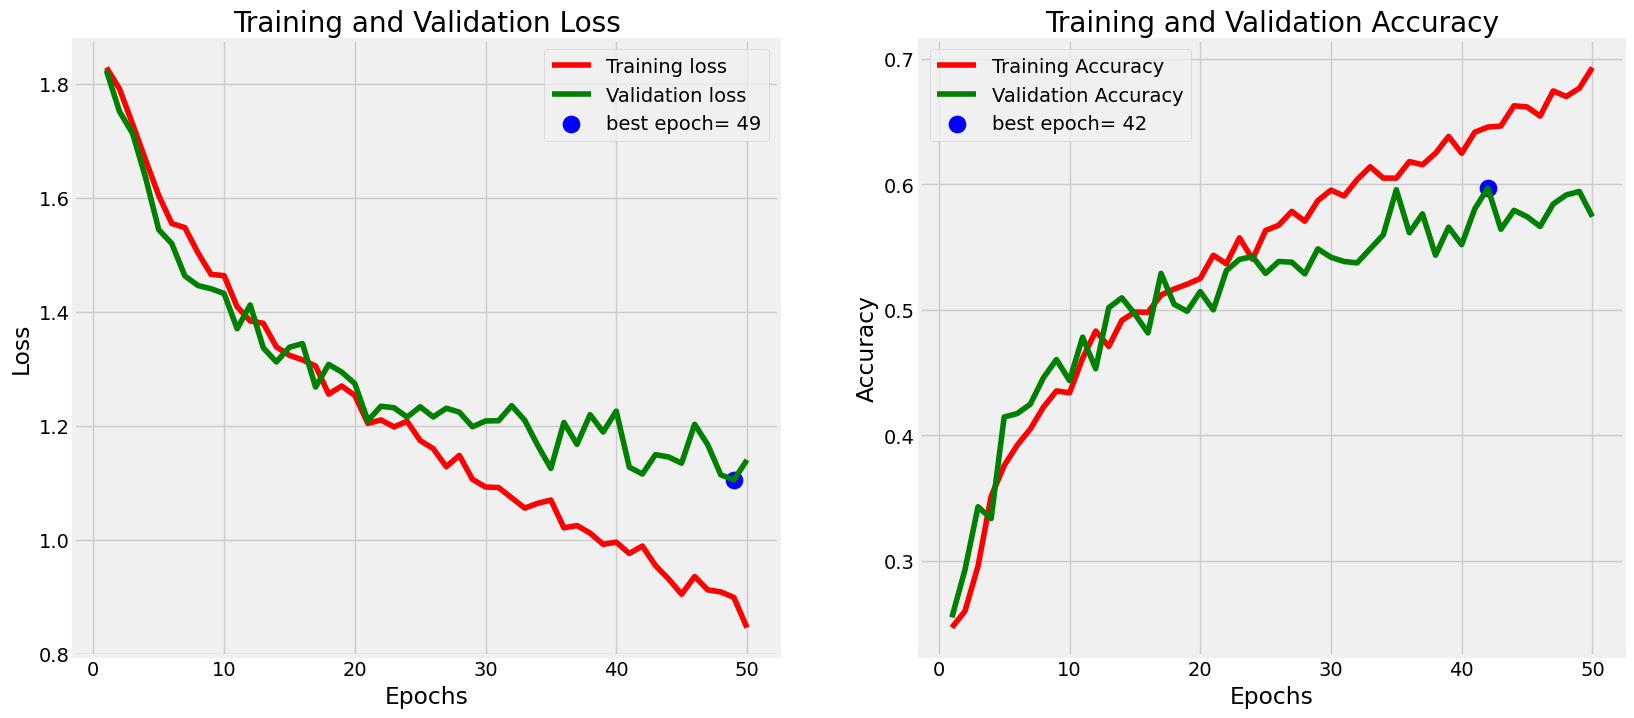

In [32]:
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

In [33]:
test_generator = ts_gen.flow_from_dataframe(
        test_df,
        x_col= 'filepaths',
        y_col= 'labels',
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

Found 7178 validated image filenames belonging to 7 classes.


In [34]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_generator, steps= test_steps, verbose= 1)
valid_score = model.evaluate(validation_generator, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_generator, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7359 - loss: 0.7684
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5968 - loss: 1.1200
97/97 ━━━━━━━━━━━━━━━━━━━━ 43s 451ms/step - accuracy: 0.5676 - loss: 1.1958
Train Loss:  0.7945045232772827
Train Accuracy:  0.7203608155250549
--------------------
Validation Loss:  1.1497610807418823
Validation Accuracy:  0.5831185579299927
--------------------
Test Loss:  1.180606722831726
Test Accuracy:  0.5679768323898315


In [36]:
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step


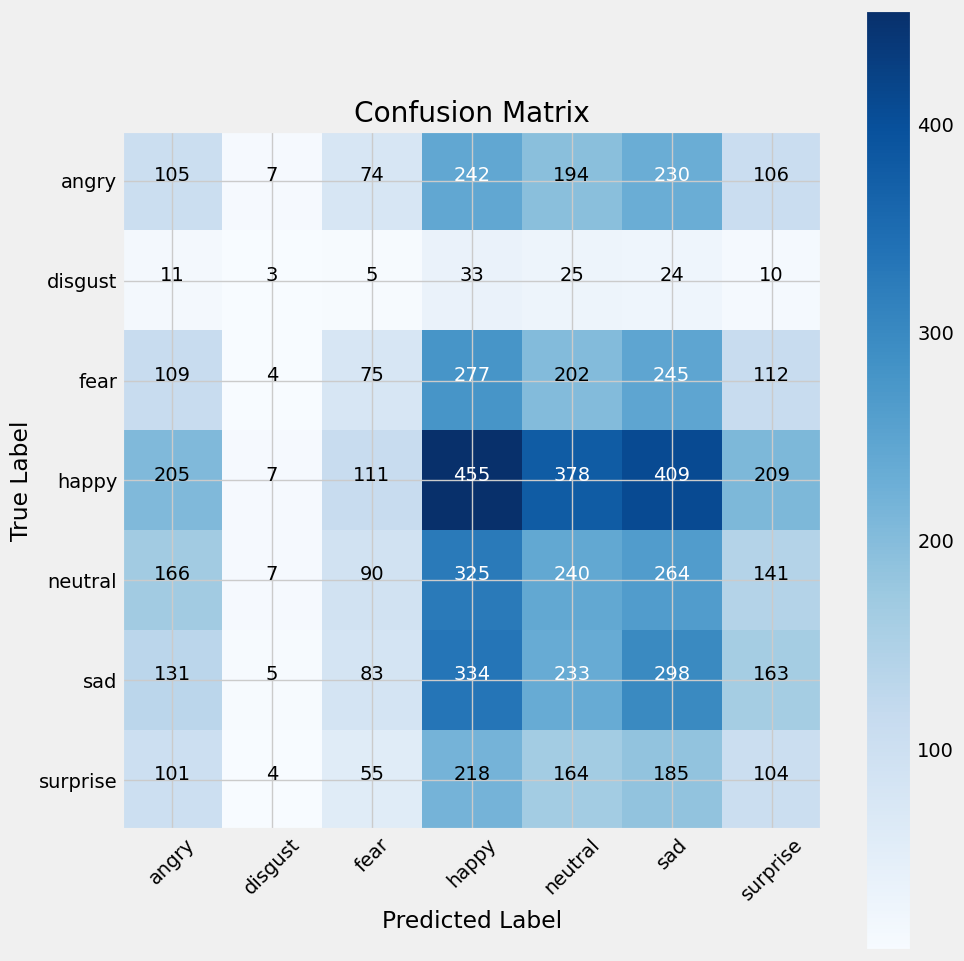

In [40]:
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [42]:
# Classification report
print(classification_report(test_generator.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

       angry       0.13      0.11      0.12       958
     disgust       0.08      0.03      0.04       111
        fear       0.15      0.07      0.10      1024
       happy       0.24      0.26      0.25      1774
     neutral       0.17      0.19      0.18      1233
         sad       0.18      0.24      0.21      1247
    surprise       0.12      0.13      0.12       831

    accuracy                           0.18      7178
   macro avg       0.15      0.15      0.15      7178
weighted avg       0.17      0.18      0.17      7178

